In [1]:
#!/usr/bin/python
# coding = utf-8

import numpy as np
from keras import metrics, regularizers, backend
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import tensorflow as tf
import random as rn
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from keras import metrics, regularizers, optimizers, backend
from keras.callbacks import TensorBoard, EarlyStopping
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Conv2D, Flatten, pooling
from keras.utils import np_utils, vis_utils
from keras import metrics, regularizers, optimizers, backend
from keras.callbacks import TensorBoard, EarlyStopping
from keras.models import Model
from keras.layers import Input, Dense, LSTM, CuDNNLSTM, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, vis_utils
from keras.models import load_model
import scipy.io as sio

Using TensorFlow backend.


In [0]:
#端到端调制识别与解调模型定义
#xTest 信号数据集
   #cumulant 高阶累积量 9个维度
   #传入AI模型 调制识别模型 model_modulation
   #QPSK解调模型 model_psk4
   #8psk解调模型  model_psk8
   #16QAM解调模型  model_qam16
   #NFeature 9高阶累积量特征个数为9
   # return yTest_demodulation 返回的是解调后的数据集
   #对输入xTest的每一行序列进行调制识别和按照识别出来的类型送入相应AI解调模型进行解调
   #对这一行序列输出每个类型QPSK 1 16QAM 2 8PSK 0的概率，看那个最大
def EndToEnd_Demodulation(xTest,cumulant,model_modulation,model_psk4,model_psk8,model_qam16):
   yPredict_type = model_modulation.predict(cumulant);
   y_Test = np.zeros((xTest.shape[0], xTest.shape[1]));
   for i in range(xTest.shape[0]):
       P_type=int(np.argmax(yPredict_type[i])); 
       if P_type == 0 :
            #取得xTest的第i行
            b=xTest[i]
            #对于行向量进行升维度从（，）二维变三维 变为（1，，）
            b=b[None,:,:]
            #print(b.shape)
            #预测得到这一行的码元概率
            a=model_psk8.predict(b);
            for j in range(a.shape[1]):
                y_Test[i][j] = int(np.argmax(a[0][j]))
       elif P_type== 1:
            #取得xTest的第i行
            b=xTest[i]
            #对于行向量进行升维度从（，）二维变三维 变为（1，，）
            b=b[None,:,:]
            #print(b.shape)
            #预测得到这一行的码元概率
            a=model_psk4.predict(b);
            for j in range(a.shape[1]):
                y_Test[i][j] = int(np.argmax(a[0][j]))
       elif P_type == 2:
            #取得xTest的第i行
            b=xTest[i]
            #对于行向量进行升维度从（，）二维变三维 变为（1，，）
            b=b[None,:,:]
            #print(b.shape)
            #预测得到这一行的码元概率
            a=model_qam16.predict(b);
            for j in range(a.shape[1]):
                y_Test[i][j] = int(np.argmax(a[0][j]))
   return y_Test

In [121]:
yPredict

array([[3., 0., 0., ..., 1., 1., 1.],
       [2., 0., 2., ..., 2., 3., 3.],
       [1., 0., 0., ..., 3., 1., 3.],
       ...,
       [0., 1., 2., ..., 0., 2., 1.],
       [2., 2., 0., ..., 3., 3., 0.],
       [2., 2., 0., ..., 1., 3., 1.]])

In [125]:
yTest

array([[3, 3, 0, ..., 2, 3, 0],
       [2, 0, 1, ..., 2, 2, 0],
       [2, 1, 3, ..., 1, 0, 0],
       ...,
       [0, 1, 2, ..., 0, 2, 1],
       [2, 2, 0, ..., 3, 3, 0],
       [2, 2, 0, ..., 1, 3, 1]], dtype=uint8)

In [132]:
    #载入必要的4PSK信号数据 -10db-20db
    #信号序列的列数
    N=100
    LOW = -10
    HIGH = 20
    GAP = 2
    #信号序列的行数
    NTest = 100
    #信号序列的列数
    L=100
    model_modulation = load_model('modulationModel.h5')
    model_psk4 = load_model('QPSKDemodulationModel.h5')
    model_psk8 = load_model('8PSKDemodulationModel.h5')
    model_qam16 = load_model('16QAMDemodulationModel.h5')
    #得到计算好的4PSK高阶累积量
    cumulant_psk4 = np.loadtxt('./test_cumulant_psk4.csv', delimiter = ',', dtype = float)
    test_data_full = sio.loadmat('test_data_demodulation_psk4.mat')
    test_data =test_data_full['test_data_demodulation_psk4']

    test_data_real = test_data.real
    test_data_imag = test_data.imag
    #x_data_real = x_data_real.reshape((1000,100))
    #x_data_imag = x_data_imag.reshape((1000,100))
    test_data_re = np.stack((test_data_real, test_data_imag), axis=2)
    xTest = test_data_re[:,0:N]
    yTest_full=sio.loadmat('test_label_demodulation_psk4.mat')
    yTest= yTest_full['test_label_demodulation_psk4']
    yTest.astype(int)

array([[3, 3, 0, ..., 2, 3, 0],
       [2, 0, 1, ..., 2, 2, 0],
       [2, 1, 3, ..., 1, 0, 0],
       ...,
       [0, 1, 2, ..., 0, 2, 1],
       [2, 2, 0, ..., 3, 3, 0],
       [2, 2, 0, ..., 1, 3, 1]])

In [0]:
#将信号输入端到端的调制识别与解调模型

#对输入的4psk信号进行调制识别与解调
yPredict=EndToEnd_Demodulation(xTest,cumulant_psk4,model_modulation,model_psk4,model_psk8,model_qam16)
 

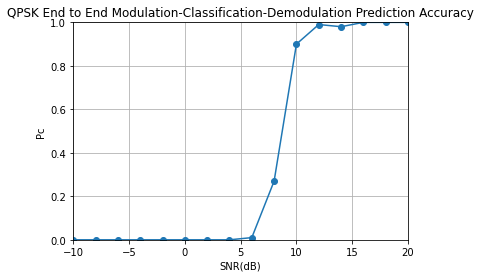

In [134]:
#解调得到的数据和 原本的标签正例数据进行比较，计算出正确率
    predict_curve = np.zeros((2, int((HIGH-LOW)/GAP) + 1)) # snr + Pc

     #第一个for循环得到x轴的刻度
    for i in range(predict_curve.shape[1]): # snr - [-10 -8 ... 18 20]
        predict_curve[0, i] = LOW + GAP * i
    #不同信噪比的信号 预测正确的个数
    for i in range(test_data_re.shape[0]): 
        snr_loc = int((test_data_re[i, L,0] - LOW)/GAP);
        for j in range(L):
          #print(yTest[i,j])
          #print(int(np.argmax(yPredict[i,j])))
          if yTest[i,j] == int(yPredict[i,j]):
            continue
          else:
            break
        #print(j)
        if j == L-1 :
          predict_curve[1, snr_loc] = predict_curve[1, snr_loc] + 1
    #不同信噪比预测正确的百分比，结果应该为噪声越大，预测准确率越低，信噪比越高，预测准确率越高
    for i in range(predict_curve.shape[1]): 
        predict_curve[1, i] = predict_curve[1, i]/(NTest)
    
    #输入测试集计算预测的准确性，可以看到snr 在10b之下的时候，由于噪声过大，模型解调正确率很低
    #当SNR大于等于10db的时候，模型接近百分之百预测正确信号的解调
    plt.plot(predict_curve[0], predict_curve[1], 'o-')

    plt.grid(True)
    #plt.legend(loc='lower right')
    plt.xlim((LOW, HIGH))
    plt.ylim((0,1))
    plt.xlabel('SNR(dB)')
    plt.ylabel('Pc')
    plt.title('QPSK End to End Modulation-Classification-Demodulation Prediction Accuracy')
    plt.savefig('QPSK_End_to_End_Modulation_Classification_Demodulation_accuracy.png', format='png')

In [135]:
#载入8psk信号数据-10db-20db
#载入必要的4PSK信号数据 -10db-20db
    #信号序列的列数
    N=100
    LOW = -10
    HIGH = 20
    GAP = 2
    #信号序列的行数
    NTest = 100
    #信号序列的列数
    L=100
    model_modulation = load_model('modulationModel.h5')
    model_psk4 = load_model('QPSKDemodulationModel.h5')
    model_psk8 = load_model('8PSKDemodulationModel.h5')
    model_qam16 = load_model('16QAMDemodulationModel.h5')
    #得到计算好的8PSK高阶累积量
    cumulant_psk8 = np.loadtxt('./test_cumulant_psk8.csv', delimiter = ',', dtype = float)
    test_data_full = sio.loadmat('test_data_demodulation_psk8.mat')
    test_data =test_data_full['test_data_demodulation_psk8']

    test_data_real = test_data.real
    test_data_imag = test_data.imag
    #x_data_real = x_data_real.reshape((1000,100))
    #x_data_imag = x_data_imag.reshape((1000,100))
    test_data_re = np.stack((test_data_real, test_data_imag), axis=2)
    xTest = test_data_re[:,0:N]
    yTest_full=sio.loadmat('test_label_demodulation_psk8.mat')
    yTest= yTest_full['test_label_demodulation_psk8']
    yTest.astype(int)

array([[0, 5, 3, ..., 7, 6, 3],
       [2, 2, 3, ..., 7, 2, 6],
       [5, 0, 6, ..., 2, 2, 3],
       ...,
       [4, 2, 6, ..., 6, 5, 1],
       [7, 0, 5, ..., 0, 0, 4],
       [7, 6, 7, ..., 6, 2, 0]])

In [0]:
#将8psk信号输入端到端的调制识别与解调模型
#对输入的8psk信号进行调制识别与解调
yPredict=EndToEnd_Demodulation(xTest,cumulant_psk8,model_modulation,model_psk4,model_psk8,model_qam16)

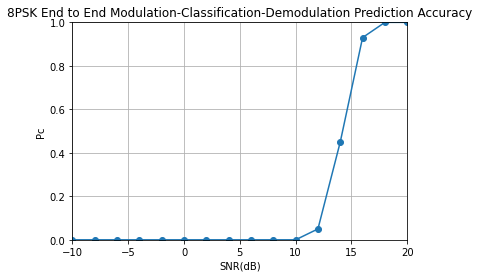

In [139]:
#解调得到的8psk数据和 原本的标签正例数据进行比较，计算出正确率
    predict_curve = np.zeros((2, int((HIGH-LOW)/GAP) + 1)) # snr + Pc
    for i in range(predict_curve.shape[1]): # snr - [-10 -8 ... 18 20]
        predict_curve[0, i] = LOW + GAP * i
    #不同信噪比的信号 预测正确的个数
    for i in range(test_data_re.shape[0]):
        snr_loc = int((test_data_re[i, L,0] - LOW)/GAP);
        for j in range(L):
          #print(yTest[i,j])
          #print(int(np.argmax(yPredict[i,j])))
          if yTest[i,j] == int(yPredict[i,j]):
            continue
          else:
            break
        #print(j)
        if j == L-1 :
          predict_curve[1, snr_loc] = predict_curve[1, snr_loc] + 1
    #不同信噪比预测正确的百分比，结果应该为噪声越大，预测准确率越低，信噪比越高，预测准确率越高
    for i in range(predict_curve.shape[1]): 
        predict_curve[1, i] = predict_curve[1, i]/(NTest)
    
    #输入测试集计算预测的准确性，可以看到snr 在10b之下的时候，由于噪声过大，模型解调正确率很低
    #当SNR大于等于10db的时候，模型接近百分之百预测正确信号的解调
    plt.plot(predict_curve[0], predict_curve[1], 'o-')

    plt.grid(True)
    #plt.legend(loc='lower right')
    plt.xlim((LOW, HIGH))
    plt.ylim((0,1))
    plt.xlabel('SNR(dB)')
    plt.ylabel('Pc')
    plt.title('8PSK End to End Modulation-Classification-Demodulation Prediction Accuracy')
    plt.savefig('8PSK_End_to_End_Modulation_Classification_Demodulation_accuracy.png', format='png')

In [140]:
#载入16QAM信号数据20db -44db
#载入必要的4PSK信号数据 -10db-20db
    #信号序列的列数
    N=100
    LOW = 20
    HIGH = 44
    GAP = 2
    #信号序列的行数
    NTest = 100
    #信号序列的列数
    L=100
    model_modulation = load_model('modulationModel.h5')
    model_psk4 = load_model('QPSKDemodulationModel.h5')
    model_psk8 = load_model('8PSKDemodulationModel.h5')
    model_qam16 = load_model('16QAMDemodulationModel.h5')
    #得到计算好的4PSK高阶累积量
    cumulant_qam16 = np.loadtxt('./test_cumulant_qam16.csv', delimiter = ',', dtype = float)
    test_data_full = sio.loadmat('test_data_demodulation_qam16.mat')
    test_data =test_data_full['test_data_demodulation_qam16']

    test_data_real = test_data.real
    test_data_imag = test_data.imag
    #x_data_real = x_data_real.reshape((1000,100))
    #x_data_imag = x_data_imag.reshape((1000,100))
    test_data_re = np.stack((test_data_real, test_data_imag), axis=2)
    xTest = test_data_re[:,0:N]
    yTest_full=sio.loadmat('test_label_demodulation_qam16.mat')
    yTest= yTest_full['test_label_demodulation_qam16']
    yTest.astype(int)

array([[ 9, 10, 11, ...,  3, 13,  5],
       [11, 14,  7, ..., 10,  4,  5],
       [ 3,  0,  9, ...,  3, 15,  3],
       ...,
       [ 6, 15, 14, ...,  7,  2,  4],
       [ 6, 15,  8, ..., 11, 15,  8],
       [ 9,  6, 12, ...,  5, 14,  5]])

In [0]:
#将16QAM信号输入端到端的调制识别与解调模型
#对输入的16qam信号进行调制识别与解调
yPredict=EndToEnd_Demodulation(xTest,cumulant_qam16,model_modulation,model_psk4,model_psk8,model_qam16)

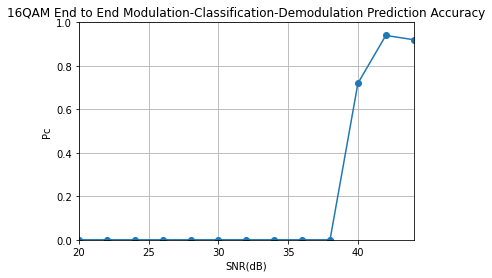

In [142]:
#解调得到的16QAM数据和 原本的标签正例数据进行比较，计算出正确率
    predict_curve = np.zeros((2, int((HIGH-LOW)/GAP) + 1)) # snr + Pc
    for i in range(predict_curve.shape[1]): # snr - [-10 -8 ... 18 20]
        predict_curve[0, i] = LOW + GAP * i
    #不同信噪比的信号 预测正确的个数
    for i in range(test_data_re.shape[0]): 
        snr_loc = int((test_data_re[i, L,0] - LOW)/GAP);
        for j in range(L):
          #print(yTest[i,j])
          #print(int(np.argmax(yPredict[i,j])))
          if yTest[i,j] == int(yPredict[i,j]):
            continue
          else:
            break
        #print(j)
        if j == L-1 :
          predict_curve[1, snr_loc] = predict_curve[1, snr_loc] + 1
    #不同信噪比预测正确的百分比，结果应该为噪声越大，预测准确率越低，信噪比越高，预测准确率越高
    for i in range(predict_curve.shape[1]): 
        predict_curve[1, i] = predict_curve[1, i]/(NTest)
    
    #输入测试集计算预测的准确性，可以看到snr 在10b之下的时候，由于噪声过大，模型解调正确率很低
    #当SNR大于等于10db的时候，模型接近百分之百预测正确信号的解调
    plt.plot(predict_curve[0], predict_curve[1], 'o-')

    plt.grid(True)
    #plt.legend(loc='lower right')
    plt.xlim((LOW, HIGH))
    plt.ylim((0,1))
    plt.xlabel('SNR(dB)')
    plt.ylabel('Pc')
    plt.title('16QAM End to End Modulation-Classification-Demodulation Prediction Accuracy')
    plt.savefig('16QAM_End_to_End_Modulation_Classification_Demodulation_accuracy.png', format='png')

In [30]:
cumulant_psk4 = cumulant_psk4[:,0:9]
yPredict_type = model_modulation.predict(cumulant_psk4);
print(np.argmax(yPredict_type[1599]))
y_Test

1


array([[3., 0., 0., ..., 1., 1., 1.],
       [2., 0., 2., ..., 2., 3., 3.],
       [1., 0., 0., ..., 3., 1., 3.],
       ...,
       [0., 1., 2., ..., 0., 2., 1.],
       [2., 2., 0., ..., 3., 3., 0.],
       [2., 2., 0., ..., 1., 3., 1.]])

In [58]:
y_Test.shape

(1600, 100)

In [0]:
yPredict_type = model_modulation.predict(cumulant_psk4);

y_Test = np.zeros((xTest.shape[0], xTest.shape[1]));

a=model_psk4.predict(xTest);
for i in range(xTest.shape[0]):
    for j in range(a.shape[1]):
        y_Test[i][j] = np.argmax(a[0][j])

In [0]:
b=xTest[0]



In [101]:
b=b[None,:,:]
b.shape

(1, 100, 2)

In [0]:
y_Test = np.zeros((xTest.shape[0], xTest.shape[1]));

In [102]:
a=model_psk4.predict(b);

print(b.shape)

(1, 100, 4)


In [0]:
i=0
for j in range(a.shape[1]):
    y_Test[i][j] = np.argmax(a[i][j])

In [68]:
a[0,3]

array([2.2745896e-04, 1.9879304e-03, 9.9531364e-01, 2.4709080e-03],
      dtype=float32)